In [ ]:
# import numpy as np
# import heapq
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# # ------------------- ENVIRONMENT SETTINGS -------------------
# # Buildings and grid bounds
# building_radius = 0.6
# building_height = 10
# grid_size = (25, 25, 25)

# buildings = []
# for x in range(0, 25, 4):
#     for y in range(0, 25, 4):
#         z = 0
#         buildings.append([x, y, z, building_radius, building_height])
# buildings = np.array(buildings)

# # Recharge points (charging stations)
# orange_points = [np.array([10, 10, 0]), np.array([20, 15, 0])]

# # Section boundaries (from Code #1)
# sections = {
#     'Section 1': (0, 8, 0, 8),
#     'Section 2': (8, 16, 0, 8),
#     'Section 3': (16, 24, 0, 8),
#     'Section 4': (0, 8, 8, 16),
#     'Section 5': (8, 16, 8, 16),
#     'Section 6': (16, 24, 8, 16),
#     'Section 7': (0, 8, 16, 24),
#     'Section 8': (8, 16, 16, 24),
#     'Section 9': (16, 24, 16, 24),
# }

# # Start and goal positions
# start = np.array([0, 0, 0])
# goal = np.array([16, 16, 0])  # Set goal within the same section for testing

# # ------------------- HELPER FUNCTIONS -------------------

# # Actions: Up, Down, Left, Right, Forward, Backward
# actions = [
#     np.array([1, 0, 0]),  # Move right
#     np.array([-1, 0, 0]), # Move left
#     np.array([0, 1, 0]),  # Move forward
#     np.array([0, -1, 0]), # Move backward
#     np.array([0, 0, 1]),  # Move up
#     np.array([0, 0, -1])  # Move down
# ]

# # Heuristic function (Euclidean distance to goal)
# def heuristic(state, goal):
#     return np.linalg.norm(state - goal)

# # Function to determine which section a point belongs to
# def get_section(point):
#     x, y, z = point
#     for section_name, bounds in sections.items():
#         x_min, x_max, y_min, y_max = bounds
#         if x_min <= x < x_max and y_min <= y < y_max:
#             return section_name
#     return None

# # Check if start and goal are in the same section
# def in_same_section(start, goal):
#     return get_section(start) == get_section(goal)

# # Collision with buildings
# def is_intersecting_with_buildings(point):
#     x, y, z = point
#     for building in buildings:
#         x_c, y_c, z_c, r, h = building
#         if np.sqrt((x - x_c)**2 + (y - y_c)**2) < r and 0 <= z <= h:
#             return True
#     return False

# # Check if at an orange recharge point
# def is_at_orange_point(state):
#     for point in orange_points:
#         if np.array_equal(state, point):
#             return True
#     return False

# # ------------------- PATHFINDING (A*) -------------------
# # A* search algorithm with charge tracking and section restriction
# def a_star_search(start, goal, max_charge):
#     same_section = in_same_section(start, goal)  # Check if both are in the same section
#     restricted_section = get_section(start) if same_section else None  # Get the section if restricted

#     # Priority queue: (f_cost, current_charge, path_cost, current_state, path_taken, charge_history)
#     pq = []
#     heapq.heappush(pq, (0 + heuristic(start, goal), max_charge, 0, tuple(start), [tuple(start)], [max_charge]))

#     # Visited dictionary to store the best charge state at each position
#     visited = {}

#     while pq:
#         # Pop the node with the lowest f_cost (f_cost = path_cost + heuristic)
#         f_cost, charge, path_cost, current_state, path, charge_history = heapq.heappop(pq)

#         # If we reach the goal, return the path and charge history
#         if current_state == tuple(goal):
#             return path, charge_history

#         # Check if current position has been visited with a better charge
#         state_key = current_state
#         if state_key in visited and visited[state_key] >= charge:
#             continue
#         visited[state_key] = charge

#         # Check if we need to recharge at an orange point
#         if is_at_orange_point(np.array(current_state)):
#             charge = max_charge  # Recharge fully

#         # Explore neighboring states (valid actions)
#         for action in actions:
#             next_state = np.array(current_state) + action
#             next_state = np.clip(next_state, 0, grid_size[0])  # Ensure within bounds

#             # Skip if restricted to the same section and next_state is outside
#             if same_section and get_section(next_state) != restricted_section:
#                 continue

#             # Skip the next state if it's colliding with buildings
#             if is_intersecting_with_buildings(next_state):
#                 continue

#             # Decrease charge for each step
#             next_charge = charge - 1

#             # Ignore if charge is less than or equal to 0
#             if next_charge <= 0:
#                 continue

#             # Calculate the new path cost
#             new_path_cost = path_cost + 1

#             # Calculate f_cost (path cost + heuristic)
#             f_cost = new_path_cost + heuristic(next_state, goal)

#             # Add next state to the priority queue as a tuple, along with the updated charge history
#             heapq.heappush(pq, (f_cost, next_charge, new_path_cost, tuple(next_state), path + [tuple(next_state)], charge_history + [next_charge]))

#     return None, None  # If no path found

# # ------------------- VISUALIZATION -------------------
# # Plotting the environment and path
# def plot_environment_and_path(path):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')

#     # Plot the obstacles (buildings)
#     def plot_cylinder(ax, x_center, y_center, radius, height):
#         z = np.linspace(0, height, 50)  # 50 points along the height of the cylinder
#         theta = np.linspace(0, 2 * np.pi, 50)  # 50 points for the circular base
#         theta_grid, z_grid = np.meshgrid(theta, z)  # Create a grid for theta and z
#         x_grid = radius * np.cos(theta_grid) + x_center  # X coordinates for the cylinder surface
#         y_grid = radius * np.sin(theta_grid) + y_center  # Y coordinates for the cylinder surface
#         ax.plot_surface(x_grid, y_grid, z_grid, color='blue', alpha=0.3)

#     # Plot the buildings
#     for building in buildings:
#         x_center, y_center, z, radius, height = building
#         plot_cylinder(ax, x_center, y_center, radius, height)

#     # Plot the recharge stations (orange points)
#     for point in orange_points:
#         ax.scatter(point[0], point[1], point[2], color='orange', s=100, label='Recharge Point')

#     # Plot the path
#     ax.plot([p[0] for p in path], [p[1] for p in path], [p[2] for p in path], color='red', marker='o', label='Path Taken')
#     ax.scatter([goal[0]], [goal[1]], [goal[2]], color='green', s=100, label='Goal')

#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title('Drone Path in 3D')
#     plt.legend()
#     plt.show()

# # ------------------- EXECUTION -------------------
# path, charge_history = a_star_search(start, goal, max_charge=65)

# if path:
#     print("Path found:", path)
#     print("Charge history:", charge_history)
#     plot_environment_and_path(np.array(path))
# else:
#     print("No path found.")



No path found.


Path found!


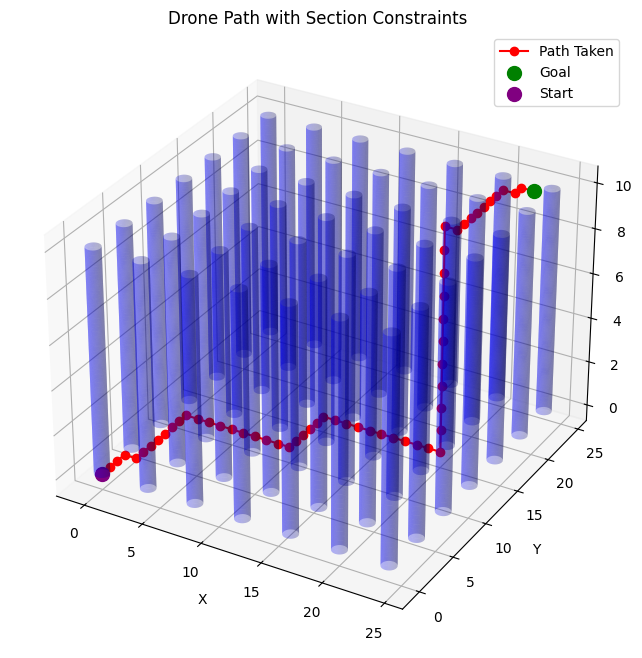

In [3]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ------------------- ENVIRONMENT SETTINGS -------------------
# Building properties
building_radius = 0.6
building_height = 10

# Create buildings
buildings = []
for x in range(0, 25, 4):
    for y in range(0, 25, 4):
        z = 0
        buildings.append([x, y, z, building_radius, building_height])
buildings = np.array(buildings)

# Recharge points
orange_points = [np.array([10, 10, 0]), np.array([20, 15, 0])]

# Grid size and maximum charge
grid_size = (25, 25, 25)
max_charge = 25

# Start and goal positions
start = np.array([0,0, 0])
goal = np.array([23, 23, 10])  # Goal within the section

# Section boundaries
sections = {
    'Section 1': (0, 8, 0, 8),
    'Section 2': (8, 16, 0, 8),
    'Section 3': (16, 24, 0, 8),
    'Section 4': (0, 8, 8, 16),
    'Section 5': (8, 16, 8, 16),
    'Section 6': (16, 24, 8, 16),
    'Section 7': (0, 8, 16, 24),
    'Section 8': (8, 16, 16, 24),
    'Section 9': (16, 24, 16, 24),
}

# Check if a point is within a given section
def is_point_in_section(point, section):
    x, y = point[:2]
    x_min, x_max, y_min, y_max = section
    return x_min <= x < x_max and y_min <= y < y_max

# Determine which section a point is in
def find_section(point):
    for section_name, bounds in sections.items():
        if is_point_in_section(point, bounds):
            return section_name
    return None

# ------------------- HELPER FUNCTIONS -------------------
actions = [
    np.array([1, 0, 0]),  # Move right
    np.array([-1, 0, 0]), # Move left
    np.array([0, 1, 0]),  # Move forward
    np.array([0, -1, 0]), # Move backward
    np.array([0, 0, 1]),  # Move up
    np.array([0, 0, -1])  # Move down
]

# Heuristic function (Euclidean distance to goal)
def heuristic(state, goal):
    return np.linalg.norm(state - goal)

# Check if the drone is at a recharge point
def is_at_orange_point(state):
    for point in orange_points:
        if np.array_equal(state, point):
            return True
    return False

# Collision detection with buildings
def is_intersecting_with_buildings(point):
    x, y, z = point
    for building in buildings:
        x_c, y_c, z_c, r, h = building
        if np.sqrt((x - x_c)**2 + (y - y_c)**2) < r and 0 <= z <= h:
            return True
    return False

# ------------------- PATHFINDING (A*) -------------------
# A* search algorithm with section logic and charge tracking
def a_star_search(start, goal, max_charge):
    # Priority queue: (f_cost, current_charge, path_cost, current_state, path_taken, charge_history)
    pq = []
    heapq.heappush(pq, (0 + heuristic(start, goal), max_charge, 0, tuple(start), [tuple(start)], [max_charge]))

    # Visited dictionary to store the best charge state at each position
    visited = {}

    # Set current section for starting point
    current_section = find_section(start)

    while pq:
        # Pop the node with the lowest f_cost (f_cost = path_cost + heuristic)
        f_cost, charge, path_cost, current_state, path, charge_history = heapq.heappop(pq)

        # If we reach the goal, return the path and charge history
        if current_state == tuple(goal):
            return path, charge_history

        # Check if current position has been visited with a better charge
        state_key = current_state
        if state_key in visited and visited[state_key] >= charge:
            continue
        visited[state_key] = charge

        # Check if we need to recharge at an orange point
        if is_at_orange_point(np.array(current_state)):
            charge = max_charge  # Recharge fully

        # Explore neighboring states (valid actions)
        for action in actions:
            next_state = np.array(current_state) + action
            next_state = np.clip(next_state, 0, grid_size[0] - 1)  # Ensure within bounds

            # Skip the next state if it's colliding with buildings
            if is_intersecting_with_buildings(next_state):
                continue

            # Decrease charge for each step
            next_charge = charge - 1

            # Ignore if charge is less than or equal to 0
            if next_charge <= 0:
                continue

            # Calculate the new path cost
            new_path_cost = path_cost + 1

            # Move between sections if needed but ensure reaching goal section eventually
            if current_section != find_section(goal):
                next_section = find_section(next_state)
                if next_section != current_section:
                    current_section = next_section

            # Calculate f_cost (path cost + heuristic)
            f_cost = new_path_cost + heuristic(next_state, goal)

            # Add next state to the priority queue as a tuple, along with the updated charge history
            heapq.heappush(pq, (f_cost, next_charge, new_path_cost, tuple(next_state), path + [tuple(next_state)], charge_history + [next_charge]))

    return None, None  # If no path found

# ------------------- VISUALIZATION -------------------
# Plotting the environment and path
def plot_environment_and_path(path):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the obstacles (buildings)
    def plot_cylinder(ax, x_center, y_center, radius, height):
        z = np.linspace(0, height, 50)  # 50 points along the height of the cylinder
        theta = np.linspace(0, 2 * np.pi, 50)  # 50 points for the circular base
        theta_grid, z_grid = np.meshgrid(theta, z)  # Create a grid for theta and z
        x_grid = radius * np.cos(theta_grid) + x_center  # X coordinates for the cylinder surface
        y_grid = radius * np.sin(theta_grid) + y_center  # Y coordinates for the cylinder surface
        ax.plot_surface(x_grid, y_grid, z_grid, color='blue', alpha=0.3)

    # Plot the buildings
    for building in buildings:
        x_center, y_center, z, radius, height = building
        plot_cylinder(ax, x_center, y_center, radius, height)

    # Plot the path
    path = np.array(path)
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color='red', marker='o', label='Path Taken')
    ax.scatter([goal[0]], [goal[1]], [goal[2]], color='green', label='Goal', s=100)
    ax.scatter([start[0]], [start[1]], [start[2]], color='purple', label='Start', s=100)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Drone Path with Section Constraints')

    plt.legend()
    plt.show()

# ------------------- MAIN EXECUTION -------------------
path, charge_history = a_star_search(start, goal, max_charge)

if path:
    print("Path found!")
    plot_environment_and_path(path)
else:
    print("No path found.")


In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

# ------------------- ENVIRONMENT SETTINGS -------------------
# Building properties
building_radius = 0.6
building_height = 10

# Create buildings
buildings = []
for x in range(0, 25, 4):
    for y in range(0, 25, 4):
        z = 0
        buildings.append([x, y, z, building_radius, building_height])
buildings = np.array(buildings)

# Recharge points
orange_points = [np.array([10, 10, 0]), np.array([20, 15, 0])]

# Grid size and maximum charge
grid_size = (25, 25, 25)
max_charge = 25

# Start position
start = np.array([0, 0, 0])

# Section boundaries
sections = {
    'Section 1': (0, 8, 0, 8),
    'Section 2': (8, 16, 0, 8),
    'Section 3': (16, 24, 0, 8),
    'Section 4': (0, 8, 8, 16),
    'Section 5': (8, 16, 8, 16),
    'Section 6': (16, 24, 8, 16),
    'Section 7': (0, 8, 16, 24),
    'Section 8': (8, 16, 16, 24),
    'Section 9': (16, 24, 16, 24),
}

# Check if a point is within a given section
def is_point_in_section(point, section):
    x, y = point[:2]
    x_min, x_max, y_min, y_max = section
    return x_min <= x < x_max and y_min <= y < y_max

# Determine which section a point is in
def find_section(point):
    for section_name, bounds in sections.items():
        if is_point_in_section(point, bounds):
            return section_name
    return None

# ------------------- HELPER FUNCTIONS -------------------
actions = [
    np.array([1, 0, 0]),  # Move right
    np.array([-1, 0, 0]), # Move left
    np.array([0, 1, 0]),  # Move forward
    np.array([0, -1, 0]), # Move backward
    np.array([0, 0, 1]),  # Move up
    np.array([0, 0, -1])  # Move down
]

# Heuristic function (Euclidean distance to goal)
def heuristic(state, goal):
    return np.linalg.norm(state - goal)

# Check if the drone is at a recharge point
def is_at_orange_point(state):
    for point in orange_points:
        if np.array_equal(state, point):
            return True
    return False

# Collision detection with buildings
def is_intersecting_with_buildings(point):
    x, y, z = point
    for building in buildings:
        x_c, y_c, z_c, r, h = building
        if np.sqrt((x - x_c)**2 + (y - y_c)**2) < r and 0 <= z <= h:
            return True
    return False

# ------------------- PATHFINDING (A*) -------------------
# A* search algorithm with section logic and charge tracking
def a_star_search(start, goal, max_charge):
    # Priority queue: (f_cost, current_charge, path_cost, current_state, path_taken, charge_history)
    pq = []
    heapq.heappush(pq, (0 + heuristic(start, goal), max_charge, 0, tuple(start), [tuple(start)], [max_charge]))

    # Visited dictionary to store the best charge state at each position
    visited = {}

    # Set current section for starting point
    current_section = find_section(start)

    while pq:
        # Pop the node with the lowest f_cost (f_cost = path_cost + heuristic)
        f_cost, charge, path_cost, current_state, path, charge_history = heapq.heappop(pq)

        # If we reach the goal, return the path and charge history
        if current_state == tuple(goal):
            return path, charge_history

        # Check if current position has been visited with a better charge
        state_key = current_state
        if state_key in visited and visited[state_key] >= charge:
            continue
        visited[state_key] = charge

        # Check if we need to recharge at an orange point
        if is_at_orange_point(np.array(current_state)):
            charge = max_charge  # Recharge fully

        # Explore neighboring states (valid actions)
        for action in actions:
            next_state = np.array(current_state) + action
            next_state = np.clip(next_state, 0, grid_size[0] - 1)  # Ensure within bounds

            # Skip the next state if it's colliding with buildings
            if is_intersecting_with_buildings(next_state):
                continue

            # Decrease charge for each step
            next_charge = charge - 1

            # Ignore if charge is less than or equal to 0
            if next_charge <= 0:
                continue

            # Calculate the new path cost
            new_path_cost = path_cost + 1

            # Move between sections if needed but ensure reaching goal section eventually
            if current_section != find_section(goal):
                next_section = find_section(next_state)
                if next_section != current_section:
                    current_section = next_section

            # Calculate f_cost (path cost + heuristic)
            f_cost = new_path_cost + heuristic(next_state, goal)

            # Add next state to the priority queue as a tuple, along with the updated charge history
            heapq.heappush(pq, (f_cost, next_charge, new_path_cost, tuple(next_state), path + [tuple(next_state)], charge_history + [next_charge]))

    return None, None  # If no path found

# ------------------- SIMULATION OF 10 RANDOM TARGET POINTS -------------------
# Generate 10 random target points and calculate path and fuel consumption
random_targets = [np.random.randint(0, grid_size[0], 3) for _ in range(10)]
paths_and_fuels = []

for i, target in enumerate(random_targets, start=1):
    path, charge_history = a_star_search(start, target, max_charge)
    fuel_consumed = max_charge - charge_history[-1] if charge_history else "N/A"
    paths_and_fuels.append((target, path, fuel_consumed))

paths_and_fuels


[(array([ 4,  2, 11]),
  [(0, 0, 0),
   (0, 1, 0),
   (0, 1, 1),
   (0, 1, 2),
   (0, 1, 3),
   (0, 1, 4),
   (0, 1, 5),
   (0, 1, 6),
   (0, 1, 7),
   (0, 1, 8),
   (0, 1, 9),
   (0, 1, 10),
   (0, 1, 11),
   (1, 1, 11),
   (2, 1, 11),
   (3, 1, 11),
   (3, 2, 11),
   (4, 2, 11)],
  17),
 (array([24,  0,  5]), None, 'N/A'),
 (array([ 2, 18, 13]), None, 'N/A'),
 (array([16, 23, 22]), None, 'N/A'),
 (array([15, 14,  5]),
  [(0, 0, 0),
   (0, 1, 0),
   (0, 2, 0),
   (0, 3, 0),
   (1, 3, 0),
   (1, 4, 0),
   (1, 5, 0),
   (1, 6, 0),
   (1, 7, 0),
   (1, 8, 0),
   (1, 9, 0),
   (1, 10, 0),
   (2, 10, 0),
   (3, 10, 0),
   (4, 10, 0),
   (5, 10, 0),
   (6, 10, 0),
   (7, 10, 0),
   (8, 10, 0),
   (9, 10, 0),
   (10, 10, 0),
   (10, 10, 1),
   (10, 10, 2),
   (10, 10, 3),
   (10, 10, 4),
   (10, 10, 5),
   (10, 11, 5),
   (10, 12, 5),
   (10, 13, 5),
   (11, 13, 5),
   (12, 13, 5),
   (13, 13, 5),
   (14, 13, 5),
   (14, 14, 5),
   (15, 14, 5)],
  14),
 (array([4, 4, 0]), None, 'N/A'),
 (arr

In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ------------------- ENVIRONMENT SETTINGS -------------------
# Building properties
building_radius = 0.6
building_height = 10

# Create buildings
buildings = []
for x in range(0, 25, 4):
    for y in range(0, 25, 4):
        z = 0
        buildings.append([x, y, z, building_radius, building_height])
buildings = np.array(buildings)

# Recharge points
orange_points = [np.array([10, 10, 0]), np.array([20, 15, 0])]

# Grid size and maximum charge
grid_size = (25, 25, 25)
max_charge = 25

# Start and goal positions
start = np.array([0, 0, 0])

# Constant target points
target_points = [
    np.array([5, 5, 5]),
    np.array([10, 15, 7]),
    np.array([15, 10, 3]),
    np.array([20, 20, 8]),
    np.array([3, 18, 12]),
    np.array([12, 5, 18]),
    np.array([8, 8, 2]),
    np.array([22, 3, 10]),
    np.array([18, 17, 6]),
    np.array([7, 15, 14])
]

# Section boundaries
sections = {
    'Section 1': (0, 8, 0, 8),
    'Section 2': (8, 16, 0, 8),
    'Section 3': (16, 24, 0, 8),
    'Section 4': (0, 8, 8, 16),
    'Section 5': (8, 16, 8, 16),
    'Section 6': (16, 24, 8, 16),
    'Section 7': (0, 8, 16, 24),
    'Section 8': (8, 16, 16, 24),
    'Section 9': (16, 24, 16, 24),
}

# Check if a point is within a given section
def is_point_in_section(point, section):
    x, y = point[:2]
    x_min, x_max, y_min, y_max = section
    return x_min <= x < x_max and y_min <= y < y_max

# Determine which section a point is in
def find_section(point):
    for section_name, bounds in sections.items():
        if is_point_in_section(point, bounds):
            return section_name
    return None

# ------------------- HELPER FUNCTIONS -------------------
actions = [
    np.array([1, 0, 0]),  # Move right
    np.array([-1, 0, 0]), # Move left
    np.array([0, 1, 0]),  # Move forward
    np.array([0, -1, 0]), # Move backward
    np.array([0, 0, 1]),  # Move up
    np.array([0, 0, -1])  # Move down
]

# Heuristic function (Euclidean distance to goal)
def heuristic(state, goal):
    return np.linalg.norm(state - goal)

# Check if the drone is at a recharge point
def is_at_orange_point(state):
    for point in orange_points:
        if np.array_equal(state, point):
            return True
    return False

# Collision detection with buildings
def is_intersecting_with_buildings(point):
    x, y, z = point
    for building in buildings:
        x_c, y_c, z_c, r, h = building
        if np.sqrt((x - x_c)**2 + (y - y_c)**2) < r and 0 <= z <= h:
            return True
    return False

# ------------------- PATHFINDING (A*) -------------------
# A* search algorithm with section logic and charge tracking
def a_star_search(start, goal, max_charge):
    pq = []
    heapq.heappush(pq, (0 + heuristic(start, goal), max_charge, 0, tuple(start), [tuple(start)], [max_charge]))

    visited = {}
    current_section = find_section(start)

    while pq:
        f_cost, charge, path_cost, current_state, path, charge_history = heapq.heappop(pq)

        if current_state == tuple(goal):
            return path, charge_history

        state_key = current_state
        if state_key in visited and visited[state_key] >= charge:
            continue
        visited[state_key] = charge

        if is_at_orange_point(np.array(current_state)):
            charge = max_charge

        for action in actions:
            next_state = np.array(current_state) + action
            next_state = np.clip(next_state, 0, grid_size[0] - 1)

            if is_intersecting_with_buildings(next_state):
                continue

            next_charge = charge - 1
            if next_charge <= 0:
                continue

            new_path_cost = path_cost + 1
            if current_section != find_section(goal):
                next_section = find_section(next_state)
                if next_section != current_section:
                    current_section = next_section

            f_cost = new_path_cost + heuristic(next_state, goal)
            heapq.heappush(pq, (f_cost, next_charge, new_path_cost, tuple(next_state), path + [tuple(next_state)], charge_history + [next_charge]))

    return None, None

# ------------------- MAIN EXECUTION -------------------
results = []
for target in target_points:
    path, charge_history = a_star_search(start, target, max_charge)
    if path:
        path_length = np.linalg.norm(np.array(path[-1]) - start)  # Calculate path length
        fuel_consumed = max_charge  # Fuel consumed is constant
        results.append({'target_point': target, 'path_length': path_length, 'fuel_consumed': fuel_consumed})

print(results)


[{'target_point': array([5, 5, 5]), 'path_length': 8.660254037844387, 'fuel_consumed': 25}, {'target_point': array([10, 15,  7]), 'path_length': 19.339079605813716, 'fuel_consumed': 25}, {'target_point': array([15, 10,  3]), 'path_length': 18.275666882497067, 'fuel_consumed': 25}, {'target_point': array([22,  3, 10]), 'path_length': 24.351591323771842, 'fuel_consumed': 25}, {'target_point': array([18, 17,  6]), 'path_length': 25.475478405713993, 'fuel_consumed': 25}, {'target_point': array([ 7, 15, 14]), 'path_length': 21.6794833886788, 'fuel_consumed': 25}]


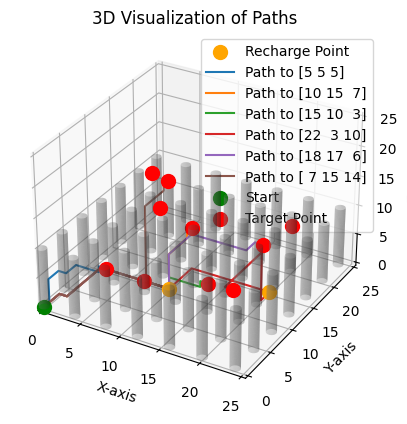

In [3]:
# ------------------- VISUALIZATION -------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("3D Visualization of Paths")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_xlim([0, grid_size[0]])
ax.set_ylim([0, grid_size[1]])
ax.set_zlim([0, grid_size[2]])

# Plot buildings as cylinders
for building in buildings:
    x, y, z, r, h = building
    phi = np.linspace(0, 2 * np.pi, 30)
    z_cylinder = np.linspace(z, z + h, 10)
    phi, z_cylinder = np.meshgrid(phi, z_cylinder)
    x_cylinder = r * np.cos(phi) + x
    y_cylinder = r * np.sin(phi) + y

    ax.plot_surface(x_cylinder, y_cylinder, z_cylinder, color='gray', alpha=0.3)

# Plot recharge points
for point in orange_points:
    ax.scatter(*point, color='orange', s=100, label='Recharge Point' if point is orange_points[0] else "")

# Plot paths to each target point
for result in results:
    target = result['target_point']
    path, _ = a_star_search(start, target, max_charge)
    path = np.array(path)
    ax.plot(path[:, 0], path[:, 1], path[:, 2], label=f"Path to {target}")

# Plot start and target points
ax.scatter(*start, color='green', s=100, label="Start")
for target in target_points:
    ax.scatter(*target, color='red', s=100, label="Target Point" if target is target_points[0] else "")

# Show the legend and plot
plt.legend()
plt.show()


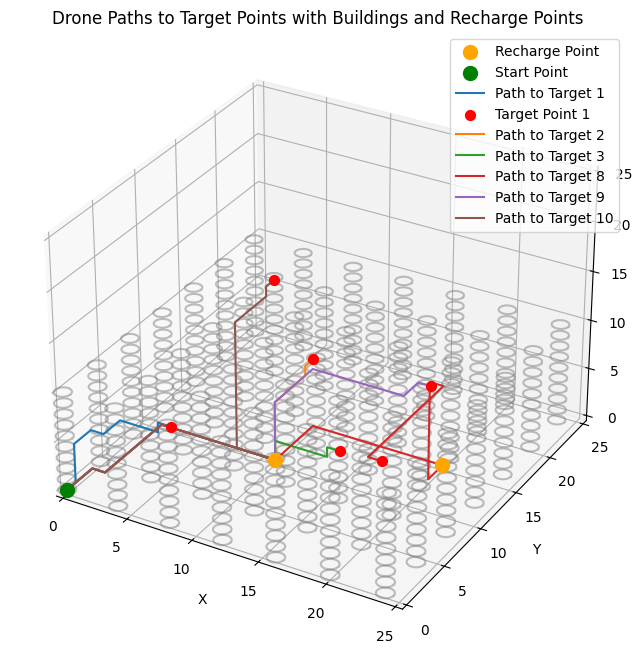

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot buildings as approximate cylinders
for building in buildings:
    x, y, z, r, h = building
    theta = np.linspace(0, 2 * np.pi, 20)
    x_circle = r * np.cos(theta) + x
    y_circle = r * np.sin(theta) + y
    for z_pos in np.linspace(z, z + h, 10):
        ax.plot(x_circle, y_circle, zs=z_pos, color='gray', alpha=0.5)

# Plot recharge points
for point in orange_points:
    ax.scatter(*point, color='orange', s=100, label="Recharge Point" if point is orange_points[0] else "")

# Plot start point
ax.scatter(*start, color='green', s=100, label='Start Point')

# Plot each path to target points
for idx, target in enumerate(target_points):
    path, charge_history = a_star_search(start, target, max_charge)
    if path:
        path = np.array(path)
        ax.plot(path[:, 0], path[:, 1], path[:, 2], label=f'Path to Target {idx+1}')
        ax.scatter(*target, color='red', s=50, label=f'Target Point {idx+1}' if idx == 0 else "")

# Plot configuration
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, grid_size[0])
ax.set_ylim(0, grid_size[1])
ax.set_zlim(0, grid_size[2])
ax.legend()
plt.title("Drone Paths to Target Points with Buildings and Recharge Points")
plt.show()
